## _*H2 ground state energy plot using different qubit mappings*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances with different fermionic mappings to quantum qubits.

This notebook populates a dictionary, that is a progammatic representation of an input file, in order to drive the Qiskit Chemistry stack. Such a dictionary can be manipulated programmatically and this is indeed the case here where we alter the molecule supplied to the driver in each loop.

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import ExactEigensolver, VQE
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

# Input dictionary to configure Qiskit Chemistry for the chemistry problem.
qiskit_chemistry_dict = {
    'problem': {'random_seed': 50},
    'driver': {'name': 'PYSCF'},
    'PYSCF': {'atom': '', 'basis': 'sto3g'},
    'operator': {'name': 'hamiltonian', 'qubit_mapping': '', 'two_qubit_reduction': False},
    'algorithm': {'name': ''}
}
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'

algorithms = ['VQE', 'ExactEigensolver']
mappings   = [QubitMappingType.JORDAN_WIGNER,
              QubitMappingType.PARITY,
              QubitMappingType.BRAVYI_KITAEV]
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 20   # Number of steps to increase by
energies  = np.empty([len(mappings), len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

aqua_globals.random_seed = 50

print('Processing step __', end='')
for i in range(steps+1):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    d = start + i*by/steps 
    for j in range(len(algorithms)):
        if algorithms[j] == 'ExactEigensolver':
            if 'optimizer' in qiskit_chemistry_dict:
                del qiskit_chemistry_dict['optimizer']
            if 'variational_form' in qiskit_chemistry_dict:
                del qiskit_chemistry_dict['variational_form']
        else:
            qiskit_chemistry_dict['optimizer'] = {'name': 'L_BFGS_B', 'maxfun': 2500}
            qiskit_chemistry_dict['variational_form'] = {'name': 'RYRZ', 'depth': 5}
        
        for k in range(len(mappings)): 
            driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
            qmolecule = driver.run()
            operator =  Hamiltonian(qubit_mapping=mappings[k], two_qubit_reduction=False)
            qubit_op, aux_ops = operator.run(qmolecule)
            if algorithms[j] == 'ExactEigensolver':
                result = ExactEigensolver(qubit_op).run()
            else:
                optimizer = L_BFGS_B(maxfun=2500)
                var_form = RYRZ(qubit_op.num_qubits, depth=5)
                algo = VQE(qubit_op, var_form, optimizer)
                result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed))

            lines, result = operator.process_algorithm_result(result)
            result['printable'] = lines
            energies[k][j][i] = result['energy']
            hf_energies[i] = result['hf_energy']  # Independent of algorithm & mapping
    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)


Couldn't find cython int routine
Couldn't find cython int routine
Processing step 20 --- complete
Distances:  [0.5   0.525 0.55  0.575 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775
 0.8   0.825 0.85  0.875 0.9   0.925 0.95  0.975 1.   ]
Energies: [[[-1.05500764 -1.07591342 -1.07905074 -1.10582393 -1.1159259
   -1.1194209  -1.129815   -1.13362146 -1.13616876 -1.13720919
   -1.13710896 -1.13601371 -1.13411673 -1.13154215 -1.12820065
   -1.12466426 -1.12013033 -1.1159871  -1.11125184 -1.1063421
   -1.10090514]
  [-1.05515979 -1.07591366 -1.09262991 -1.10591805 -1.11628601
   -1.12416092 -1.12990478 -1.13382622 -1.13618945 -1.13722138
   -1.13711707 -1.13604436 -1.13414767 -1.13155121 -1.12836188
   -1.12467175 -1.12056028 -1.11609624 -1.11133942 -1.10634211
   -1.10115033]]

 [[-1.05513399 -1.07587044 -1.09262978 -1.10591805 -1.11628601
   -1.12416092 -1.12990478 -1.13382572 -1.13618933 -1.13720732
   -1.13671373 -1.13604395 -1.13413801 -1.13155121 -1.12831815
   -1.12465795 -1.12056028

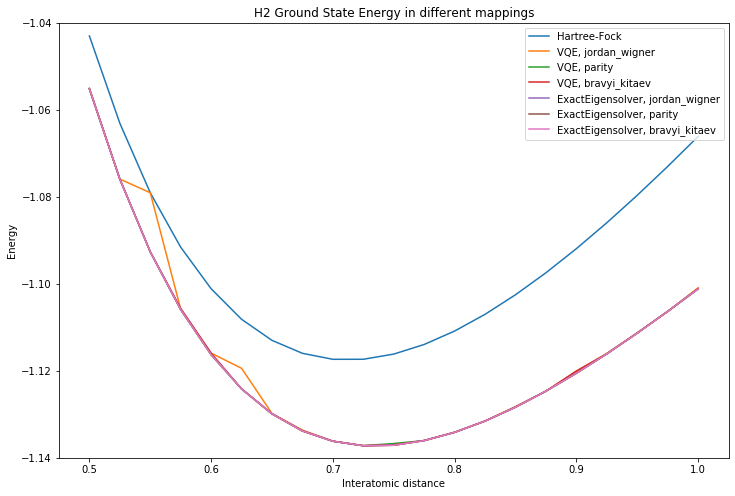

In [2]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.ylim(-1.14, -1.04)
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    for k in range(len(mappings)):
        pylab.plot(distances, energies[k][j], label=algorithms[j] + ", " + mappings[k].value)
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy in different mappings')
pylab.legend(loc='upper right')
pylab.show()

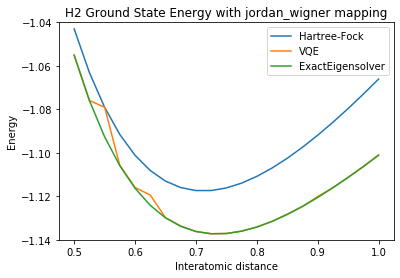

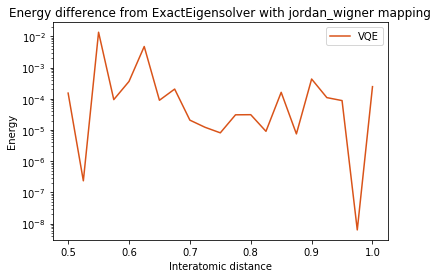

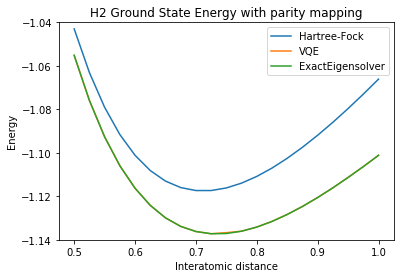

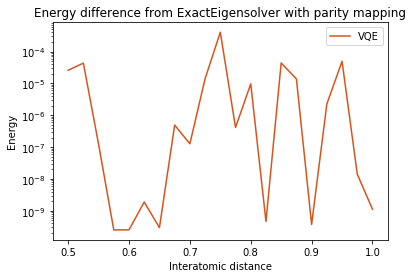

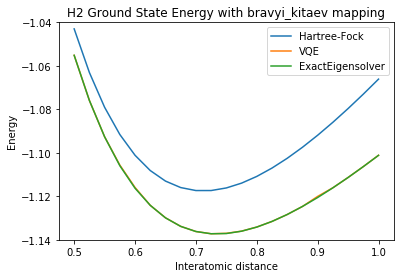

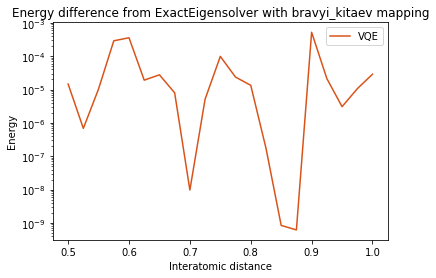

In [3]:
pylab.rcParams['figure.figsize'] = (6, 4)
for k in range(len(mappings)):
    pylab.ylim(-1.14, -1.04)
    pylab.plot(distances, hf_energies, label='Hartree-Fock')
    for j in range(len(algorithms)):
        pylab.plot(distances, energies[k][j], label=algorithms[j])
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.title('H2 Ground State Energy with {} mapping'.format(mappings[k].value))
    pylab.legend(loc='upper right')
    pylab.show()
    
    #pylab.plot(distances, np.subtract(hf_energies, energies[k][1]), label='Hartree-Fock')
    pylab.plot(distances, np.subtract(energies[k][0], energies[k][1]), color=[0.8500, 0.3250, 0.0980], label='VQE')
    pylab.xlabel('Interatomic distance')
    pylab.ylabel('Energy')
    pylab.yscale('log')
    pylab.title('Energy difference from ExactEigensolver with {} mapping'.format(mappings[k].value))
    pylab.legend(loc='upper right')
    pylab.show()